In [26]:
import src.data.dataDario as dl
import src.utilis.utilisDario as ut
import src.plotting as pl 
import pandas as pd
import numpy as np
from IPython.display import display
import warnings

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

## Load and Prepare Data
First, we load all the necessary data files using our custom processing function. This function handles reading the CSVs, cleaning subreddit names, and filtering the datasets based on the list of approved subreddits.

In [24]:
COUNTRY_FILE = "data/subreddit_matches_approved.csv"   
EMBEDDINGS_FILE = "data/web-redditEmbeddings-subreddits.csv" 
TITLE_FILE = "data/soc-redditHyperlinks-title.tsv"
BODY_FILE = "data/soc-redditHyperlinks-body.tsv"
APPROVED_MAPPING_FILE = "data/subreddit_matches_approved.csv"
COUNTRY_EXPANDED = "data/df_country_expanded.csv"
MAP_COUNTRY_EXPANDED = "data/country_matches_map_exp.csv"

df_countries=dl.load_country_subreddits(COUNTRY_FILE)
df_embeddings=dl.load_embeddings(EMBEDDINGS_FILE)
df_embeddings_countries= dl.filter_embeddings_by_country(df_embeddings, df_countries)
df_posts=dl.load_post_data(TITLE_FILE, BODY_FILE)
df_post_with_1_country, df_post_between_countries=dl.filter_posts_by_country(df_posts, df_countries)
df_country_exp = pd.read_csv(COUNTRY_EXPANDED)

print(f"\nLoaded {len(df_countries)} approved country-related subreddits.")
print(f"Loaded {len(df_embeddings)} embeddings.")
print(f"Loaded {len(df_embeddings_countries)} embeddings representing country subreddits.")
print(f"Loaded {len(df_post_with_1_country)} posts with at least one approved country-related subreddit.")
print(f"Loaded {len(df_post_between_countries)} posts between approved country-related subreddits.")

Loading approved subreddits from: data/subreddit_matches_approved.csv
Loading embeddings from: data/web-redditEmbeddings-subreddits.csv
Filtering embeddings...
Embedding filtering complete.
Loading and combining post data...
Filtering posts by country...
Post filtering complete.

Loaded 1424 approved country-related subreddits.
Loaded 51278 embeddings.
Loaded 812 embeddings representing country subreddits.
Loaded 48104 posts with at least one approved country-related subreddit.
Loaded 7075 posts between approved country-related subreddits.


Notice that the embedding file for the countries has only 1912 rows while the approved subreddits are more than 3600. It's because a lot of country-related subreddits don't appear in the embedding file

# Familiarizing ourselves with the main dataset

### Description of variables in the dataset

SOURCE_SUBREDDIT: the subreddit where the link originates

TARGET_SUBREDDIT: the subreddit where the link ends

POST_ID: the post in the source subreddit that starts the link

TIMESTAMP: time time of the post

POST_LABEL: label indicating if the source post is explicitly negative towards the target post. 

The value is -1 if the source is negative towards the target, and 1 if it is neutral or positive. 

The label is created using crowd-sourcing and training a text based classifier, and is better than simple sentiment analysis of the posts. Please see the reference paper for details.

POST_PROPERTIES: a vector representing the text properties of the source post, listed as a list of comma separated numbers. The vector elements are the following:

01. Number of characters
2. Number of characters without counting white space
3. Fraction of alphabetical characters
4. Fraction of digits
5. Fraction of uppercase characters
6. Fraction of white spaces
7. Fraction of special characters, such as comma, exclamation mark, etc.
8. Number of words
9. Number of unique works
10. Number of long words (at least 6 characters)
11. Average word length
12. Number of unique stopwords
13. Fraction of stopwords
14. Number of sentences
15. Number of long sentences (at least 10 words)
16. Average number of characters per sentence
17. Average number of words per sentence
18. Automated readability index
19. Positive sentiment calculated by VADER
20. Negative sentiment calculated by VADER
21. Compound sentiment calculated by VADER
22. LIWC_Funct
23. LIWC_Pronoun
24. LIWC_Ppron
25. LIWC_I
26. LIWC_We
27. LIWC_You
28. LIWC_SheHe
29. LIWC_They
30. LIWC_Ipron
31. LIWC_Article
32. LIWC_Verbs
33. LIWC_AuxVb
34. LIWC_Past
35. LIWC_Present
36. LIWC_Future
37. LIWC_Adverbs
38. LIWC_Prep
39. LIWC_Conj
40. LIWC_Negate
41. LIWC_Quant
42. LIWC_Numbers
43. LIWC_Swear
44. LIWC_Social
45. LIWC_Family
46. LIWC_Friends
47. LIWC_Humans
48. LIWC_Affect
49. LIWC_Posemo
50. LIWC_Negemo
51. LIWC_Anx
52. LIWC_Anger
53. LIWC_Sad
54. LIWC_CogMech
55. LIWC_Insight
56. LIWC_Cause
57. LIWC_Discrep
58. LIWC_Tentat
59. LIWC_Certain
60. LIWC_Inhib
61. LIWC_Incl
62. LIWC_Excl
63. LIWC_Percept
64. LIWC_See
65. LIWC_Hear
66. LIWC_Feel
67. LIWC_Bio
68. LIWC_Body
69. LIWC_Health
70. LIWC_Sexual
71. LIWC_Ingest
72. LIWC_Relativ
73. LIWC_Motion
74. LIWC_Space
75. LIWC_Time
76. LIWC_Work
77. LIWC_Achiev
78. LIWC_Leisure
79. LIWC_Home
80. LIWC_Money
81. LIWC_Relig
82. LIWC_Death
83. LIWC_Assent
84. LIWC_Dissent
85. LIWC_Nonflu
86. LIWC_Filler

LIWC - linguistic inquiry and word count (codebook: https://www.liwc.app/static/documents/LIWC-22%20Manual%20-%20Development%20and%20Psychometrics.pdf)

### 1. Look at the dataset

In [17]:
display(df_posts.head())

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08..."
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049..."
2,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,"85.0,85.0,0.752941176471,0.0235294117647,0.082..."
3,nfl,cfb,1u4sjvs,2013-12-31 17:37:55,1,"1124.0,949.0,0.772241992883,0.0017793594306,0...."
4,playmygame,gamedev,1u4w5ss,2014-01-01 02:51:13,1,"715.0,622.0,0.777622377622,0.00699300699301,0...."


We can see that the DataFrame of all the posts contains the source and target of each post as well as several properties related to the posts themselves. 

### 2. Look at the total number of unique subreddits and posts

In [ ]:
# Combine both source and target columns into a single Pandas Series
all_subreddits_series = pd.concat([df_posts['SOURCE_SUBREDDIT'], df_posts['TARGET_SUBREDDIT']])

# Get the unique values from this combined series and convert to a list
unique_subreddit_list = all_subreddits_series.unique().tolist()
print(f"Found {len(unique_subreddit_list)} unique subreddits.")

# Display the total number of posts in the dataset
total_posts = len(df_posts)
print(f"Found {total_posts} posts.")

Found 67180 unique subreddits.
Found 858488 posts.


### 3.  Expand properties column
Here we create a separate column for each value in the properties column.

In [21]:
#  Split POST_PROPERTIES into columns
df_posts[ut.post_props_cols] = df_posts["PROPERTIES"].str.split(",", expand=True).astype(float)
df_combined = df_posts.drop(columns=["PROPERTIES"])

### 4. Study the average properties of the different subreddits

In [ ]:
# First get subreddit counts
subreddit_counts = df_combined["SOURCE_SUBREDDIT"].value_counts()

# Keep only subreddits with at least 20 posts
valid_subreddits = subreddit_counts[subreddit_counts >= 20].index

# Now compute averages for those
avg_props_by_subreddit = (
    df_combined[df_combined["SOURCE_SUBREDDIT"].isin(valid_subreddits)]
    .groupby("SOURCE_SUBREDDIT")[ut.post_props_cols]
    .mean()
)

display(avg_props_by_subreddit.head())

,num_chars,num_chars_no_space,frac_alpha,frac_digits,frac_upper,frac_spaces,frac_special,num_words,num_unique_words,num_long_words,...,LIWC_Achiev,LIWC_Leisure,LIWC_Home,LIWC_Money,LIWC_Relig,LIWC_Death,LIWC_Assent,LIWC_Dissent,LIWC_Nonflu,LIWC_Filler
SOURCE_SUBREDDIT,,,,,,,,,,,,,,,,,,,,,
100daysofrejection,38.066667,31.600000,0.621454,0.129779,0.132037,0.195114,0.053653,7.466667,7.422222,0.866667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
100movies365days,1877.361111,1673.722222,0.702896,0.047292,0.022451,0.114269,0.135543,271.777778,148.888889,49.222222,...,0.002299,0.052544,0.000252,0.000546,0.000576,0.001099,0.000537,0.000245,0.000775,0.000757
13point1,84.125000,71.375000,0.774844,0.012727,0.124862,0.156525,0.055904,14.000000,13.250000,3.541667,...,0.030635,0.173018,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002451,0.000000
195,148.000000,129.320000,0.781407,0.008233,0.181420,0.147186,0.063175,25.480000,16.920000,3.840000,...,0.002806,0.009080,0.000187,0.005420,0.000040,0.000833,0.009586,0.001737,0.005429,0.000607
1984isreality,211.687500,179.906250,0.802653,0.006236,0.113757,0.150318,0.040793,35.187500,27.500000,8.656250,...,0.011160,0.004992,0.008231,0.013284,0.002564,0.004811,0.000762,0.001362,0.000000,0.000120


Here we can look at the top 5 subreddits for any of the properties. We can for example look at the 5 subreddits with the highest money related sentiment.

In [ ]:
top5_subreddits = {}

for col in ut.post_props_cols:
    # For each metric, take the top 5 subreddits
    top5_subreddits[col] = (
        avg_props_by_subreddit[[col]]
        .sort_values(by=col, ascending=False)
        .head(5)
    )

# Display the top 5 subreddits for sentiment negative as an example
print("Top 5 subreddits by avg money related sentiment:\n")
display(top5_subreddits["LIWC_Money"]) # If you want to see another metric, change the column name here

Top 5 subreddits by avg money related sentiment:



,LIWC_Money
SOURCE_SUBREDDIT,
accountinghumor,0.128074
bankruptcysocal,0.099859
chinesecoins,0.094618
medicalcosts,0.094013
studentloandefaulters,0.092900


# Mapping Subreddits to Countries
To understand country-specific interactions, we first needed to identify which subreddits belong to which countries. This notebook uses two different sets of country mappings at different stages:

1. The Approved List (Used First)
Generation: An initial automated mapping was created (in make_initial_subreddit_maps.ipynb and filter_matches.ipynb). This found obvious matches (e.g., brasilonreddit -> Brazil) but also incorrect ones (e.g., askinsurance -> France).

Verification: This initial list was manually reviewed, and each match was either "approved" or "rejected".

Usage: For the first part of our analysis, we use only this manually approved list to ensure high accuracy.

2. The Expanded List (Used Later)
Generation: Later in this notebook, we introduce a new, much larger list of subreddit-to-country mappings. This list also includes matches made based on states and cities and linkes them to the relevant country. 

Verification: This expanded list is a raw, automated output and has not been manually approved yet. (We plan to verify this list at a later time).

Usage: We use this unapproved list for the second part of our analysis to explore broader trends with a larger dataset, accepting that it contains unverified data.

### 1. Map subreddits to the country they belong to and look at their average properties
Here we can look at which countries have the highest and lowest values for certain properties. 

In [ ]:
# Map posts to countries using the approved mapping
posts_with_countries = ut.map_posts_to_countries(df_combined, APPROVED_MAPPING_FILE)
country_posts_df = posts_with_countries.dropna(subset=['country'])

# First, get post counts per country 
# We use 'country_posts_df' which has NaN countries removed
country_post_counts = country_posts_df["country"].value_counts()

# Keep only countries with at least 20 posts 
min_posts_threshold = 20
valid_countries = country_post_counts[country_post_counts >= min_posts_threshold].index

print(f"Found {len(valid_countries)} countries with at least {min_posts_threshold} posts.")

# Now compute averages for *those* countries
# We filter the DataFrame first, then groupby
avg_props_by_country = (
    country_posts_df[country_posts_df["country"].isin(valid_countries)]
    .groupby("country")[ut.post_props_cols] 
    .mean()
)

Found 73 countries with at least 20 posts.


In [ ]:
top5_countries = {}
low5_countries = {}

for col in ut.post_props_cols:
    # For each metric, take the top 5 countries
    top5_countries[col] = (
        avg_props_by_country[[col]]
        .sort_values(by=col, ascending=False)
        .head(5)
    )
    low5_countries[col] = (
        avg_props_by_country[[col]]
        .sort_values(by=col, ascending=True)
        .head(5)
    )  

# Display the top 5 countries for sentiment negative as an example
print("Top 5 countries by avg religion related sentiment:\n")
display(top5_countries["LIWC_Relig"]) # If you want to see another metric, change the column name here

print("Bottom 5 countries by avg religion related sentiment:\n")
display(low5_countries["LIWC_Relig"]) # Change the column name here as well if you want

Top 5 countries by avg religion related sentiment:



,LIWC_Relig
country,
Sri Lanka,0.014706
Israel,0.012629
Mongolia,0.012075
Saudi Arabia,0.011277
Bangladesh,0.010517


Bottom 5 countries by avg religion related sentiment:



,LIWC_Relig
country,
Albania,0.000000
Bulgaria,0.000000
Estonia,0.000000
Hong Kong,0.000039
Jamaica,0.000048


Above, we look at the 5 countries that had the highest and lowest average score for religious sentiments in the posts from the subreddits mapped to spesific countries. 

Top 5: The high scores for Sri Lanka, Israel, Saudi Arabia, Bangladesh, and Mongolia are expected, as religion is central to national identity and daily life in these countries.

Bottom 5: The low scores for Albania, Bulgaria, Estonia, and Hong Kong are also plausible. These are regions known for high rates of secularism or post-communist atheism.

Potential Outlier: The low score for Jamaica is the only surprise, as it's generally considered a very religious country. This anomaly might be due to data limitations, such as a small or biased sample of mapped subreddits.

Overall, the findings strongly mirror global trends, distinguishing between highly religious and highly secular nations.

### 2. Country interactions
We look at all posts that have the source and target as a country and then study the number of interactions between these countries.

In [ ]:
# Process using the APPROVED list 
approved_country_interactions, merged_approved = ut.process_country_interactions(
    df_combined, 
    APPROVED_MAPPING_FILE, 
    remove_self_loops=True
)

print(f"--- Approved Country Interactions ({len(approved_country_interactions)} rows) ---")
display(approved_country_interactions.head(10))


--- Approved Country Interactions (899 rows) ---


,source_country,target_country,n_interactions
920,United Kingdom,Ireland,62
449,Iran,United States,47
372,India,Pakistan,39
662,Pakistan,India,35
491,Israel,"Palestine, State of",33
267,France,Canada,32
472,Ireland,United Kingdom,30
680,"Palestine, State of",Israel,28
126,Brazil,Portugal,26
132,Canada,Australia,25


Based on these results, the mappings appear to be highly relevant and effective.

The top-ranking interactions are not random. They clearly reflect significant real-world relationships:

Geographic & Cultural Neighbors: The high volume of interactions between the United Kingdom and Ireland, as well as between India and Pakistan, highlights strong regional and cultural connections (and rivalries).

Geopolitical Hotspots: The prominent ranking of pairs like Iran and the United States, and Israel and Palestine (in both directions), strongly indicates that the mappings are successfully capturing communities engaged in intense, real-world geopolitical discourse.

Linguistic & Historical Ties: The presence of France/Canada and Brazil/Portugal further validates the mappings by identifying well-known historical and linguistic connections.

In conclusion, the fact that the aggregated data mirrors known global relationships so closely serves as a strong validation. It shows the approved mapping list is successfully identifying distinct country-specific communities and capturing their most significant online interactions.

# Clusters based on embeddings

### 1. Prepare Data
First, we'll use a function from our `utilis` module to separate the subreddit names from the embedding vectors and scale the vectors. This scaling step is essential for clustering algorithms to work correctly.

In [ ]:
scaled_data, subreddit_labels = ut.prepare_embeddings_for_clustering(df_embeddings)

Preparing embeddings for clustering...
Scaling features using StandardScaler...
Data prepared: 51278 items, 300 features.


### 2. Find Optimal Number of Clusters (k)

We can't just guess how many clusters to create. We'll run a K-Means "Elbow Analysis" on a sample of the data.

**How to Read This Plot:** Look for the "elbow" of the arm—the point where the line starts to flatten out. This point is usually a good choice for the number of clusters. Adding more clusters after this point gives diminishing returns.

Calculating K-Means elbow (wide range)... (using a sample of 5000 items)
  Testing k=10...
  Testing k=50...
  Testing k=100...
  Testing k=150...
  Testing k=200...
  Testing k=250...
  Testing k=300...
  Testing k=500...
  Testing k=700...
  Testing k=800...
  Testing k=1000...
Wide-range elbow calculations complete.
Plotting K-Means elbow graph...


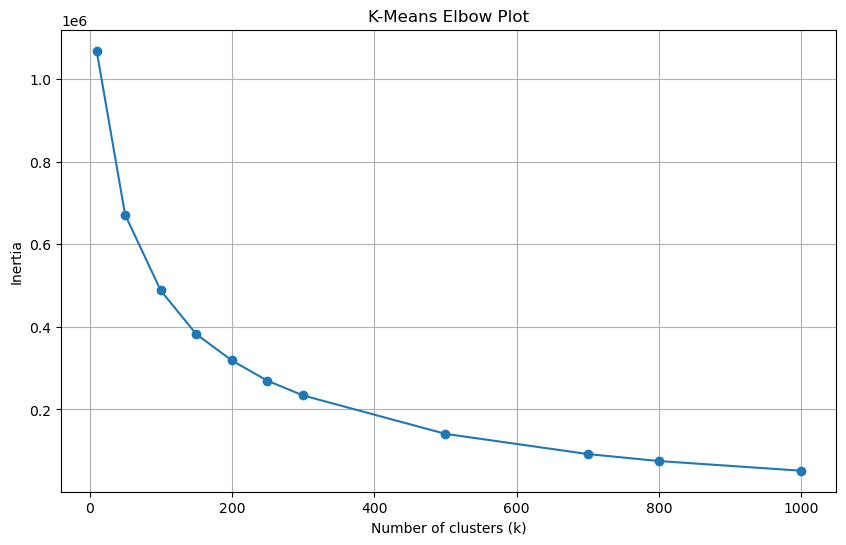

In [ ]:
# This will take few minutes to run
k_value_list=[10, 50, 100, 150, 200, 250, 300, 500, 700, 800, 1000]

elbow_df = ut.calculate_kmeans_elbow_wide(scaled_data, k_value_list, n_samples=5000)

pl.plot_kmeans_elbow(elbow_df)

### 3. Run Final Clustering & Visualization

Now, looking at the elbow plot above we can choose k=500. 

This function will:
1.  Run the final K-Means clustering on the **full 50k+ dataset**.
2.  Run **t-SNE**, a powerful algorithm that reduces the 300+ dimensions down to 2D (x, y) so we can plot them.
3.  Create an interactive scatter plot.

In [ ]:
# --- CHOOSE YOUR PARAMETERS HERE ---
N_CLUSTERS = 500  # Your number of clusters
MIN_SIZE = 300     # Your minimum size requirement
PERPLEXITY = 50   

tsne_df, all_cluster_labels = ut.run_clustering_and_tsne(
    scaled_data, 
    subreddit_labels, 
    n_clusters=N_CLUSTERS,
    min_cluster_size=MIN_SIZE,
    perplexity=PERPLEXITY  
)


Running final K-Means clustering with k=500 on 51278 items...
K-Means complete.
Finding valid clusters with > 300 members...
Found 24 valid clusters (out of 500) meeting the size criteria.
Running t-SNE with perplexity=50... (sampling 15000 items)
t-SNE complete.
Combining and filtering t-SNE results...
Returning 11355 items (from the sample) that belong to the 24 valid clusters.


### 4. Manually Label Clusters

Now we'll inspect the clusters. The cell below will get a sample of subreddits from all valid clusters.

In [ ]:
valid_clusters = set(tsne_df['cluster'].astype(int))

# Build the full dataframe of all subreddits and their cluster IDs
full_df = pd.DataFrame({
    'subreddit': subreddit_labels,
    'cluster': all_cluster_labels
})
    
# Filter this full dataframe to only include subreddits in valid clusters
valid_df = full_df[full_df['cluster'].isin(valid_clusters)]
    
# Get samples from our valid clusters
cluster_samples = ut.get_cluster_samples(
    valid_df['subreddit'].values,
    valid_df['cluster'].values,
    n_samples=100  # Show 100 samples from each
)
    
# Print the samples for inspection
for cluster_id, subs in cluster_samples.items():
        print(f"\n--- Cluster {cluster_id} ---")
        print(subs)

Getting samples from each cluster...
Returning samples for 24 total clusters.

--- Cluster 1 ---
['wowstreams', 'cumshop', 'transgenderuk', 'ageplaying', 'r4rasian', 'greenlightquality', 'mugi2lancar', 'perfumeexchange', 'gonewildscrubs', 'dayztrade', 'new_eden_link_bot', 'ashleymadisonhack', 'paintballbst', 'erotica', 'myfreecams', 'nucleusmarket', 'meetpeople', 'clans', 'gtagivers', 'canadianmoms', 'mind', 'ps4clans', 'linerangers', 'pietsmiet', 'makingsense', 'popularcreators', 'cuckoldcommunity', 'initium', 'musicproduction', 'callofcthulhu', 'smallpenishumiliation', 'transgamers', 'jetwaterpipes', 'slrep', 'computebazaar', 'bitcoinbeg', 'stories', 'slashdiabloevents', 'r4rmelbourne', 'farawaykingdom', 'collegeessayreview', 'guessmybf', 'edgyedits', 'prodmgmt', 'imagesofhumanity', 'phantomofthekill', 'lcms', 'shouldimod', 'scoliosis', 'todaydeals', 'ojokdipaluta', 'funkamateur', 'technology3', 'avengersacademyios', 'rape_roleplay', 'overwatch_lfg', 'originalmusic', 'argaming', 'bee

In [ ]:
label_map = {
    # --- HIGH CLARITY: NSFW / Pornography ---
    '35': 'Pornography (General/Hardcore)',
    '106': 'Pornography (Fetish/Niche)',
    '252': 'Pornography (Specific Niches)',

    # --- HIGH CLARITY: Gaming & Fandom ---
    '347': 'NSFW (Porn, Selfies, Misc)',
    '114': 'Video Gaming (General)',
    '327': 'PC Gaming, Hardware & Mods',

    # --- HIGH CLARITY: Politics & News ---
    '119': 'US Politics (Contentious)',
    '419': 'Politics, Science & Social Issues',

    # --- HIGH CLARITY: Hobbies / Local / University ---
    '85': 'Business, Hobbies & Learning',
    '89': 'Local, University & Tech Hobbies',
    '391': 'Images & GIFs (SFW)',
    '490': 'Local, University & Products',
    '454': 'Celebrities, Models & Fashion',
    '27': 'Local/Regional & Hobbies',
    
    # --- MEDIUM CLARITY: Mixed Themes ---
    '54': 'Gaming, Fandom & Circlejerks',
    '245': 'Politics, Science & Global News',
    '187': 'Misc / Gaming, Personals & Trading',
    '275': 'General Reddit Interests (SFW)',

    # --- LOW CLARITY: "Junk" / User-Spam ---
    '1': 'Misc / Personals & Trading (Junk)',
    '2': 'Misc / Unclear (Junk)',
    '20': 'Misc / Unclear (Junk)',
    '91': 'Misc / NSFW & User-Spam (Junk)',
    '254': 'Misc / User-Spam & NSFW (Junk)',
    '335': 'Misc / User-Specific & Bots (Junk)',
}

# --- Now, we plot using the new labels ---

pl.plot_labeled_cluster_map(tsne_df, label_map)


Generating labeled interactive cluster map...


# Faction Analysis using Embeddings
This analysis attempts to find "strict" subreddits (those that are semantically closer to their own country's subreddits than to any other) and their closest neighbors based on embedding distance. 


In [ ]:
df_strict = ut.find_strict_subreddits(df_countries, df_embeddings_countries)
print(f"Found {len(df_strict)} 'strict' subreddits.")
print("\nTop 10 countries by number of 'strict' subreddits:")
display(df_strict.groupby("predicted_country").size().sort_values(ascending=False).head(10))

Found 121 'strict' subreddits.

Top 10 countries by number of 'strict' subreddits:


predicted_country
Ireland        4
Sweden         3
New Zealand    3
Ukraine        3
Oman           3
Chile          3
Czechia        2
Slovenia       2
Brazil         2
Egypt          2
dtype: int64

In [ ]:
closest_df = ut.find_closest_dissimilar_subreddits(df_strict, df_embeddings)
print("\nClosest subreddits from different countries (based on embedding distance):")
display(closest_df.head(10))


Closest subreddits from different countries (based on embedding distance):


,subreddit,predicted_country,most_similar_subreddit,most_similar_country,similarity_score
0,nomansskythegame,Oman,malta,Malta,0.294778
1,sweden,Sweden,brasilivre,Brazil,0.304301
2,romania,Romania,chile,Chile,0.353255
3,ireland,Ireland,israel,Israel,0.323851
4,newzealand,New Zealand,lebanon,Lebanon,0.395280
5,ukraina,Ukraine,privacyrus,Cyprus,0.627782
6,israel,Israel,palestine,"Palestine, State of",0.640246
7,christmas,Christmas Island,cambodia,Cambodia,0.569371
8,svenskpolitik,Sweden,brasilivre,Brazil,0.366193
9,puertorico,Puerto Rico,bulgaria,Bulgaria,0.284074


As we can see performing the analysis on embedding distance is not leading us to correct results even when considering only subreddit strongly related to countries. The closest subreddit always belong to a country that is not geographical/cultural/political related.

# Faction Analysis using Positive Posts

### 1. Factions creation

Let's look at the raw post count originating from each country's subreddits to understand general activity levels. Here we are using the larger list of country mappings that have not been manually approved yet.

In [ ]:
country_activity = ut.calculate_country_activity(df_post_with_1_country, df_countries)
print("Top 20 most active countries by post volume:")
display(country_activity.head(20))

Top 20 most active countries by post volume:


,country,num_posts
0,USA,18211
1,Canada,4491
2,Japan,2600
3,India,2354
4,Australia,1566
5,France,1510
6,Italy,1423
7,United Kingdom,1175
8,Ireland,1155
9,Brazil,1082


We can clearly see that there is a big difference in the number of posts associated to each country so it is recommended to normalized every country by the number of posts

This is a more robust analysis. It builds a network graph where countries are nodes. The edge weight is based on the number of positive posts, **normalized by the total activity of each country**. This normalization prevents large countries (like Canada or USA) from dominating all factions simply due to high post volume.

This method helps identify strong communities (factions) based on *relative* interaction patterns.

In [ ]:
factions_summary_norm, factions_df_norm = ut.detect_normalized_factions(df_post_with_1_country, df_countries)
print("--- Factions based on Normalized Positive Interactions ---")
display(factions_summary_norm)

--- Factions based on Normalized Positive Interactions ---


,faction,countries,num_countries
0,0,"[Denmark, Serbia, Estonia, Moldova, Republic o...",33
1,1,"[Angola, China, Myanmar, Gabon, Vietnam, Japan...",29
2,2,"[Morocco, Greece, Kenya, North Macedonia, Unit...",14
3,3,"[Azerbaijan, India, Armenia, Palestine, State ...",13
4,4,"[Guyana, Trinidad and Tobago, Guatemala, Mexic...",12
5,5,"[Spain, Luxembourg, Honduras, Venezuela, Malaw...",7
6,6,"[Bolivia, Plurinational State of, Uruguay, Chi...",6
7,7,"[Iran, Bahrain, Algeria, Afghanistan, Tajikist...",6
8,8,"[Tuvalu, Palau, Vanuatu, Samoa, Fiji, Tonga]",6
9,9,"[Dominica, Haiti, Puerto Rico, Cuba, Cayman Is...",5


### 2. Interactive world map

In [ ]:
pl.plot_faction_world_map(factions_df_norm, title="World Map of Normalized Factions")

Mapping country names to ISO codes...
Generating Plotly map...


### 3. Missing Countries
Some countries may not appear in a faction if they have no positive interactions, only negative ones, or are otherwise disconnected from the main graph.

In [ ]:
missing_df = ut.diagnose_unfactioned_countries(
    df_countries, 
    factions_df_norm, 
    df_post_with_1_country
)

print(f"\n--- Summary of Unfactioned Countries ---")
display(missing_df)


Diagnosing unfactioned countries...
Mapping countries to post data...
Total approved countries: 192
Countries in factions: 138
Countries to diagnose: 54
Diagnosis complete.

--- Summary of Unfactioned Countries ---


,country,reason
0,Andorra,had positive posts but was isolated (not linke...
1,Anguilla,had positive posts but was isolated (not linke...
2,Antarctica,had positive posts but was isolated (not linke...
3,Bahamas,had positive posts but was isolated (not linke...
4,Barbados,had positive posts but was isolated (not linke...
5,Belize,had positive posts but was isolated (not linke...
6,Benin,had positive posts but was isolated (not linke...
7,Bermuda,had positive posts but was isolated (not linke...
8,Botswana,had positive posts but was isolated (not linke...
9,Bouvet Island,had positive posts but was isolated (not linke...


### 4.Faction Dynamics Over Time
Here, we analyze how factions change from quarter to quarter using the source-normalized method.

In [ ]:
df_post_between_mapped = ut.map_countries_to_posts(df_post_between_countries, df_countries)

q_factions_norm_df = ut.analyze_source_normalized_factions_over_time(df_post_between_mapped)
print("Quarterly Faction Summary (Source-Normalized):")
display(q_factions_norm_df)

Quarterly Faction Summary (Source-Normalized):


,faction,countries,num_countries,year_quarter
0,0,"[France, Germany, Switzerland, Belgium, Luxemb...",7,2014Q1
1,1,"[Sweden, Norway, Singapore, Malaysia, Viet Nam...",7,2014Q1
2,2,"[Israel, South Africa, Palestine, State of, Je...",6,2014Q1
3,3,"[China, North Korea, Vietnam, South Korea, Jap...",6,2014Q1
4,4,"[Mali, Ireland, Finland, Estonia, USA]",5,2014Q1
...,...,...,...,...
171,8,"[India, Sri Lanka, Venezuela]",3,2017Q2
172,9,"[Albania, Greece]",2,2017Q2
173,10,"[Cuba, Thailand]",2,2017Q2
174,11,"[Liberia, Mali]",2,2017Q2


Which countries consistently appear in the same faction together over time? A high fraction means a strong, stable bond.

In [ ]:
stable_pairs_norm = ut.find_stable_pairs(q_factions_norm_df)
print("Most Stable Country Pairs (Source-Normalized):")
display(stable_pairs_norm.head(15))

Most Stable Country Pairs (Source-Normalized):


,country1,country2,quarters_together,fraction_quarters_together
0,India,Pakistan,11,0.785714
1,Denmark,Sweden,10,0.714286
2,North Korea,South Korea,10,0.714286
3,Indonesia,Malaysia,9,0.642857
4,Japan,South Korea,9,0.642857
5,Croatia,Serbia,9,0.642857
6,Australia,New Zealand,9,0.642857
7,Brazil,Portugal,9,0.642857
8,Malaysia,Singapore,9,0.642857
9,Argentina,Uruguay,9,0.642857


#### Loyalty Score
Which countries tend to switch factions most often? A low score means the country frequently changes its primary allies.

In [ ]:
loyalty_norm = ut.calculate_loyalty_scores(q_factions_norm_df)
print("Most 'Loyal' Countries (Most likely to stay with the same allies, Score < 1.0):")
display(loyalty_norm.sort_values("loyalty_score", ascending=False).head(15))

Most 'Loyal' Countries (Most likely to stay with the same allies, Score < 1.0):


,country,loyalty_score,total_quarters
0,North Korea,0.909091,11
1,Armenia,0.818182,11
2,Nepal,0.800000,10
3,Pakistan,0.785714,14
4,India,0.785714,14
5,Portugal,0.750000,12
6,"Bolivia, Plurinational State of",0.750000,4
7,Paraguay,0.750000,4
8,Jersey,0.727273,11
9,South Korea,0.714286,14


#### Faction Switching Analysis
Can negative posts in a *previous* quarter explain why a country switched factions in the *current* quarter?

In [ ]:
switch_triggers = ut.find_switch_triggers(q_factions_norm_df, df_post_between_mapped)
print("Switches potentially triggered by prior negative interactions:")
display(switch_triggers.head(15))

Switches potentially triggered by prior negative interactions:


,country,from_faction,to_faction,previous_quarter,switch_quarter,neg_posts_prior,neg_allies_involved
0,China,0,2,2016Q1,2016Q2,4,[USA]
1,Viet Nam,8,0,2016Q2,2016Q3,3,[Liberia]
2,India,0,8,2017Q1,2017Q2,3,"[Nepal, Pakistan]"
3,Liberia,0,1,2016Q3,2016Q4,2,[Viet Nam]
4,Russia,0,3,2016Q4,2017Q1,2,[Ukraine]
5,New Zealand,9,0,2015Q4,2016Q1,2,[Australia]
6,USA,3,2,2015Q1,2015Q2,2,[Viet Nam]
7,India,0,4,2016Q2,2016Q3,2,[Nepal]
8,Japan,0,10,2016Q1,2016Q2,2,"[South Korea, USA]"
9,India,4,0,2016Q3,2016Q4,1,[Nepal]


Not enough posts to explain a cause for switching factions

### 5.Signed Network Visualization
Finally, let's visualize the overall network. This graph shows the net sentiment (positive posts - negative posts) between all countries.

- **Nodes** are colored by the faction they belong to (from the normalized analysis).
- **Green Edges** = Net Positive Interaction
- **Red Edges** = Net Negative Interaction
- **Edge Width** = Total number of posts (log-scaled)

In [ ]:
print("Mapping countries to post data for network plot...")

df_post_1_mapped = ut.map_countries_to_posts(df_post_with_1_country, df_countries)
print("Mapping complete.")

Mapping countries to post data for network plot...
Mapping complete.



Generating Signed Network Plot...
Signed Network Plot saved as signed_network_plot.png


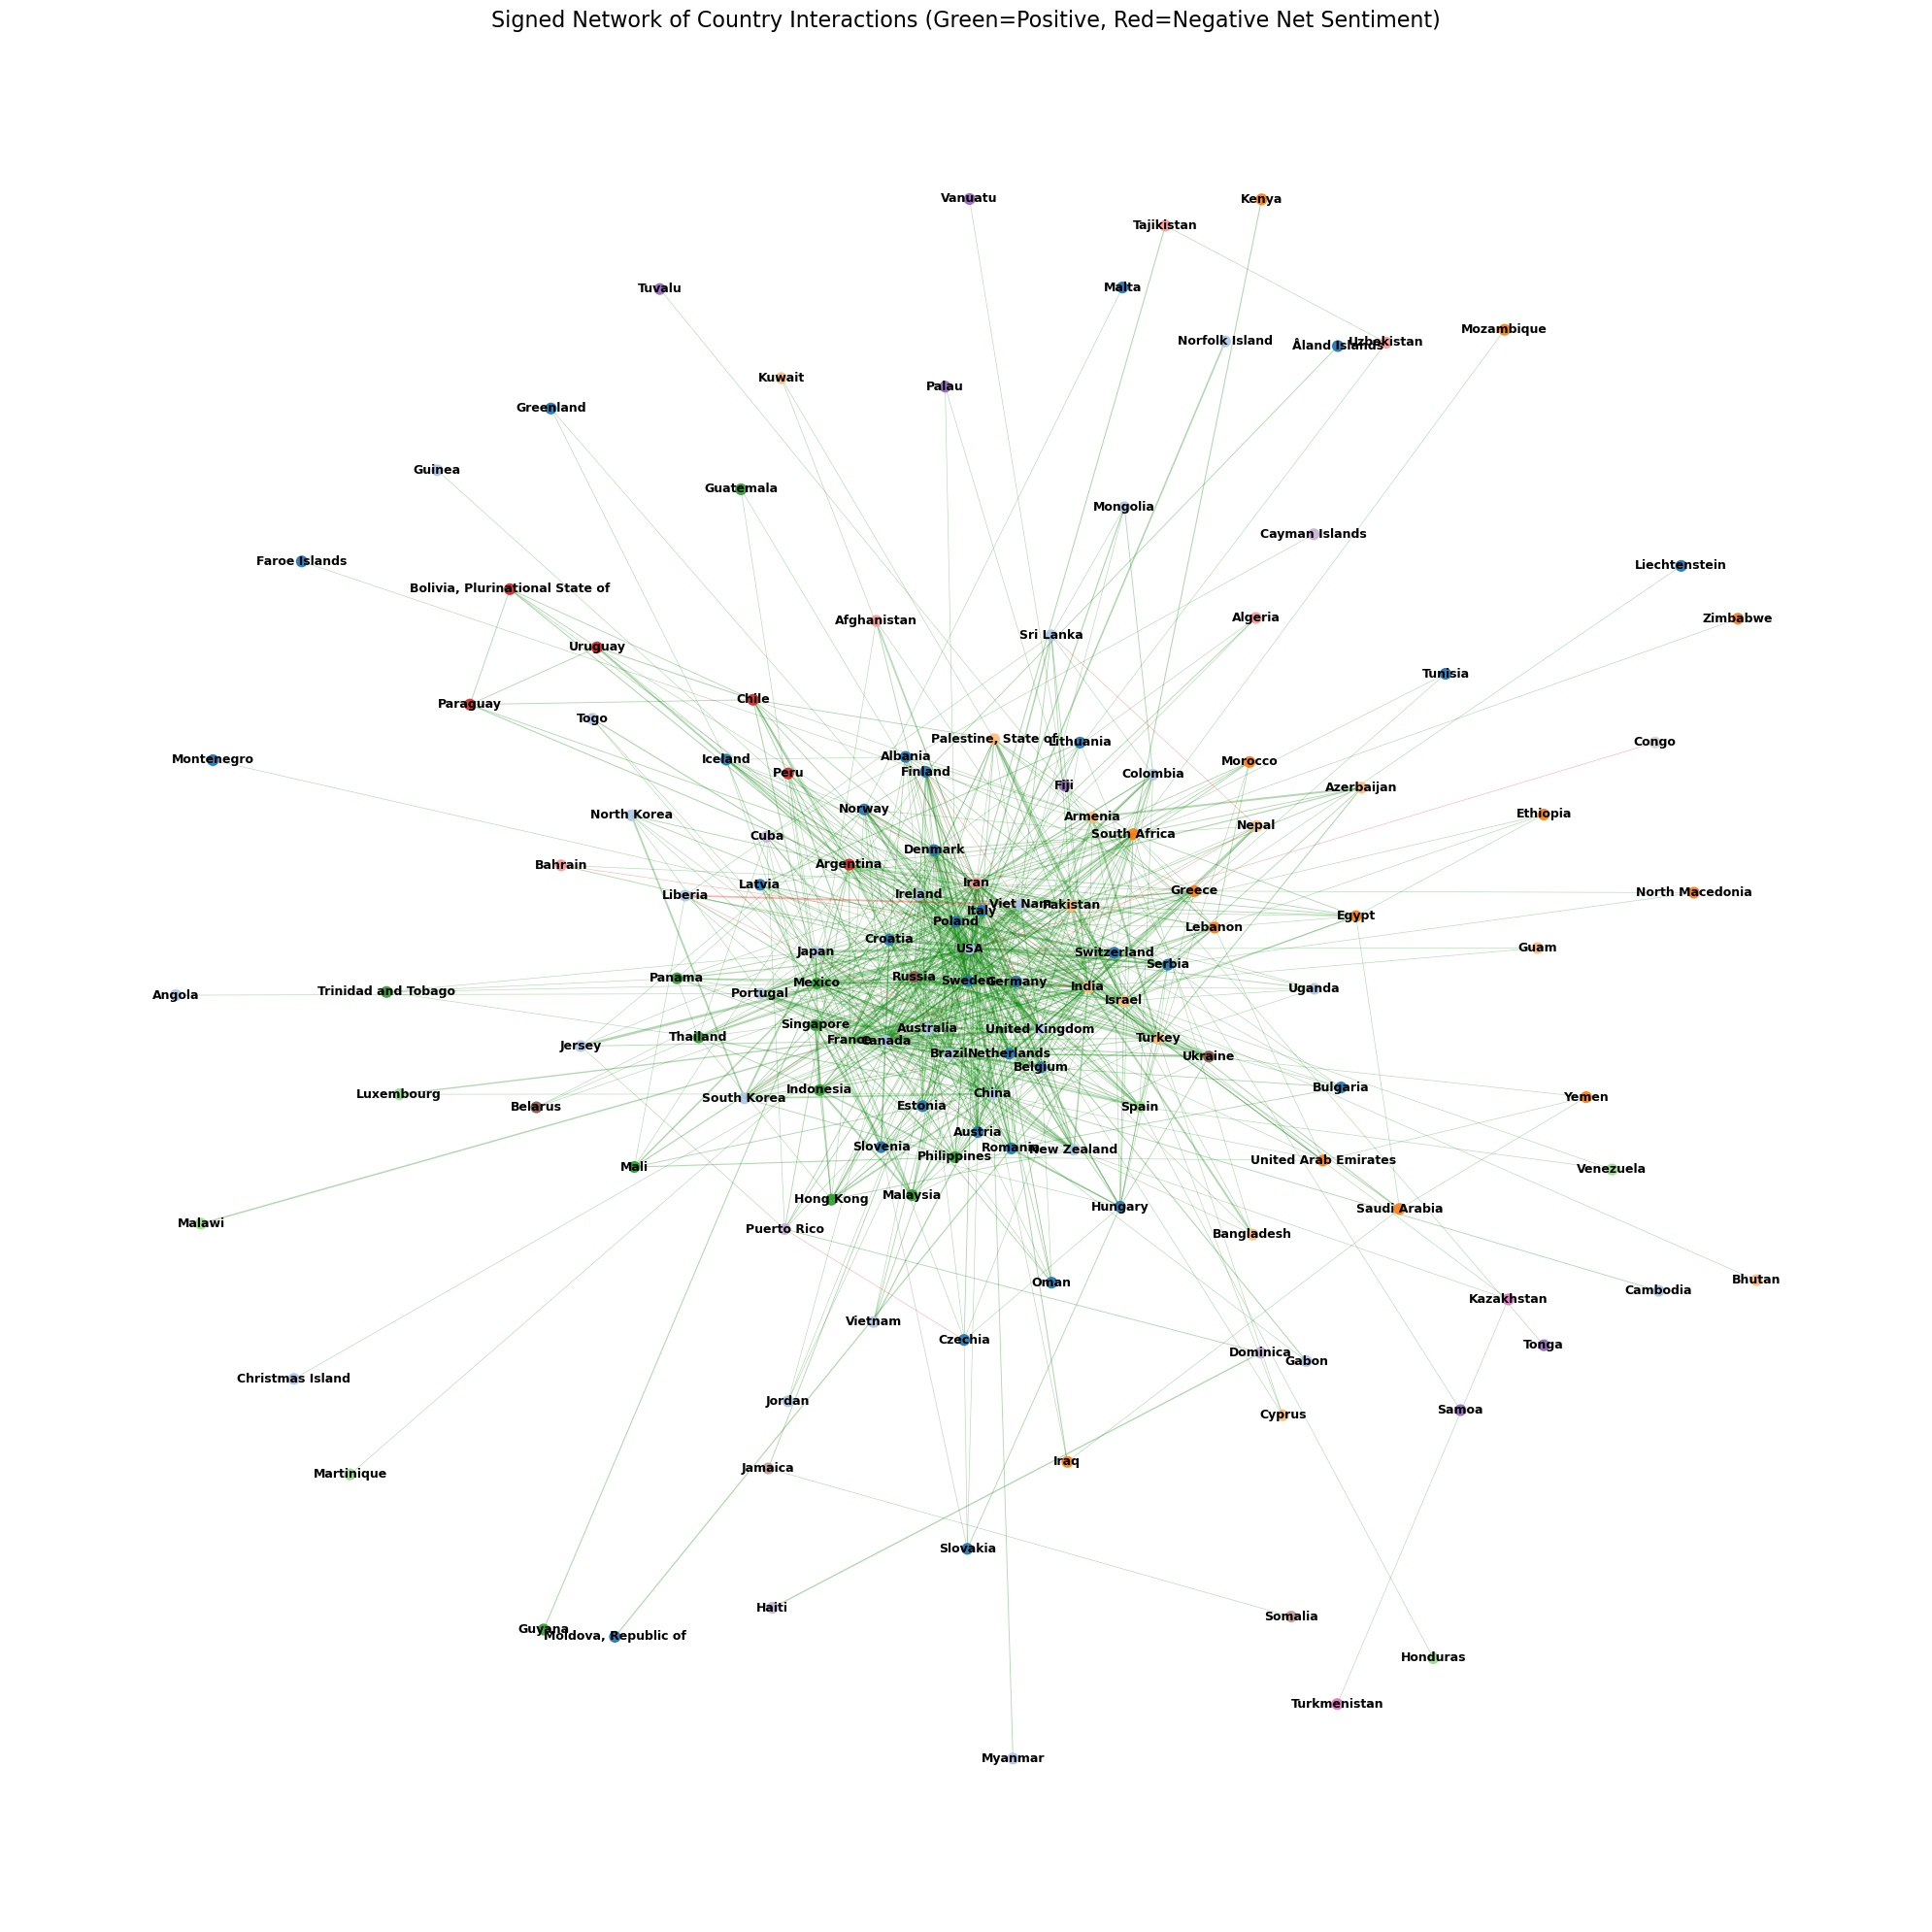

In [ ]:
pl.plot_signed_network(
    df_post_1_mapped, 
    factions_df_norm, 
    title="Signed Network of Country Interactions (by Faction)"
)

We can clearly see that biggest states are in the middle and are the vertices of many edges reflecting their user's community activity while small states and island are very far and isolated 


# Global Conditional Probability of Reciprocity

In simple terms, we want to answers the question:
> "If Country A posts to Country B, what is the probability that Country B will post back to Country A within 7 days?"

## Function Analysis: `response_global`

### 1. Preparation and Filtering

* **Clean:** Drops any rows where the source or target country is missing, and converts the `TIMESTAMP` column into a proper datetime format.
* **Create `pair_key`:** To analyze a pair like (Italy, France), it needs to group all `Italy -> France` and `France -> Italy` interactions together. It uses a `frozenset` because `frozenset({'Italy', 'France'})` is the *same* as `frozenset({'France', 'Italy'})`. This lets it group all interactions for a pair, regardless of direction.
* **Filter `valid_pairs`:** It counts how many interactions each pair has. If a pair only has one post (e.g., Italy posted to France, but France *never* posted), it's impossible to measure reciprocity. So, it only keeps pairs with 2 or more interactions.

### 2. The Deterministic Logic 

* **Loop:** It loops through every `valid_pair` (e.g., the `{'Italy', 'France'}` pair).
* **Find the "True" Initiator:** For each pair, it gets all their interactions and finds the **very first post** (`first_interaction = df_pair.iloc[0]`).
* **Assign Roles:** Based on that *first post*, it permanently assigns the roles:
    * `country_A` = The `SOURCE_COUNTRY` of that very first post (The "Initiator").
    * `country_B` = The `TARGET_COUNTRY` of that very first post (The "Responder").
* **Separate Data:** It then creates two new DataFrames:
    * `df_A_to_B`: All posts where the Initiator (A) posted to the Responder (B).
    * `df_B_to_A`: All posts where the Responder (B) posted back to the Initiator (A).

### 3. The 7-Day Window (The `merge_asof`)

* **`pd.merge_asof`:** This is a powerful time-series function. It takes *every single post* from `df_A_to_B` (an "initiation") and searches in `df_B_to_A` to find the **first response** that happened *after* it (`direction='forward'`).
* **Calculate `response_time`:** It creates a new column by subtracting the initiation time from the response time.
* **Check Window:** It checks if this `response_time` is less than or equal to 7 days.
* **Count Totals:**
    * `total_initiators_global` is incremented by the total number of initiations (the length of `df_A_to_B`).
    * `total_responses_global` is incremented only by the number of responses that were `True` for the 7-day check.

### 4. Final Calculation

* It divides `total_responses_global` by `total_initiators_global` to get the final conditional probability (e.g., `P(B->A | A->B)`).
* It prints this final result.

In [19]:
ut.response_global(df_country_exp)

/Users/noemiortona/Documents/MTE/ADA/progetto_main/src/utilis/utilisDario.py:843: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



DataFrame ready. Analyzing 446 pairs.


Analyzing pairs: 100%|██████████| 446/446 [00:00<00:00, 480.51it/s]


--- Global Reciprocity Analysis ---
Total 'initiator' interactions (A->B) analyzed: 1454
Total responses (B->A) within 7 days: 266
GLOBAL Conditional Probability P(B->A | A->B in 7d): 18.29%


# Conditional Probability of Reciprocity within the same country

In simple terms, we want to answers the question:
> "If a post from Subreddit A is directed to Subreddit B (both in the same country), what is the probability that Subreddit B will post back to Subreddit A within 7 days?"

## Function Analysis: `response_intra_country`

## 1. Preparation and Filtering

* **Clean & Filter:** It only keeps rows where `SOURCE_COUNTRY` and `TARGET_COUNTRY` are the same (and not null), AND where `SOURCE_SUBREDDIT` is different from `TARGET_SUBREDDIT`.
* **Create `pair_key`:** Just like the global function, it uses a `frozenset` to group subreddit pairs (e.g., `frozenset({'r/news', 'r/politics'})`).
* **Filter `valid_pairs`:** It only keeps pairs of subreddits that have interacted 2 or more times.

## 2. The Deterministic Logic 

* **Loop:** It loops through every `valid_pair` (e.g., the `{'r/news', 'r/politics'}` pair).
* **Find the "True" Initiator:** For each pair, it gets all their interactions (which are already sorted by time) and finds the **very first post** (`first_interaction = df_pair.iloc[0]`).
* **Assign Roles:** Based on that *first post*, it permanently assigns the roles:
    * `Sub_A` = The `SOURCE_SUBREDDIT` of that first post (The "Initiator").
    * `Sub_B` = The `TARGET_SUBREDDIT` of that first post (The "Responder").
* **Separate Data:** It creates two DataFrames:
    * `df_A_to_B`: All posts from Subreddit A to Subreddit B.
    * `df_B_to_A`: All posts from Subreddit B back to Subreddit A.

## 3. The 7-Day Window (The `merge_as_of`)

This is where the 7-day probability is calculated.

* **`pd.merge_asof`:** It takes *every single post* from `df_A_to_B` (an "initiation") and searches in `df_B_to_A` to find the **first response** that happened *after* it (`direction='forward'`).
* **Count Totals:** It counts how many initiations (`total_initiators_global`) and how many valid responses within 7 days (`total_responses_global`) were found.

## 4. Final Calculation

* It divides the total responses by the total initiations to get the final conditional probability.
* It prints this final result.

In [21]:
ut.response_intra_country(df_country_exp)

Found 9439 intra-country interactions (between different subreddits).
Analyzing 836 unique subreddit pairs.


Analyzing subreddit pairs: 100%|██████████| 836/836 [00:01<00:00, 576.86it/s]


--- Global INTRA-COUNTRY Reciprocity Analysis ---
Total 'initiator' interactions (SubA -> SubB) analyzed: 3730
Total responses (SubB -> SubA) within 7 days: 273
GLOBAL Conditional Probability P(SubB->SubA | SubA->SubB in 7d): 7.32%


# Linguistic Style Mirroring Test

We want to answer the question:
> "When a post (A) triggers a reply (B), does the *style* of the reply (B) unconsciously mimic the *style* of the original post (A)?"

To prove this, we can't just measure the similarity of reply pairs. We need to prove that they are *more similar than they would be by pure chance*. This requires a:

1.  **Test Group:** A list of similarity scores from *actual* reciprocal pairs (A replied to B).
2.  **Control Group:** A list of similarity scores from *randomly selected* pairs (X and Y, who have no connection).
3.  **Comparison:** A statistical test (like a T-test) to see if the Test Group's similarity is significantly higher than the Control Group's.

This experimental design is complex. To keep the code clean and readable, we split the logic:

* **`find_reciprocity_pairs_and_similarity()` (The "Helper" Function):** This function has one very specific and difficult job: to find every valid `A -> B => B -> A` interaction and return the list of their similarity scores. This will be our **Test Group**.
* **`response_similarity()` (The "Main" Function):** This function acts as the "orchestrator." It defines the experiment, calls the helper function to get the Test Group, creates the **Control Group** itself, and then performs the final statistical comparison and visualization.

---
## The Helper Function: `find_reciprocity_pairs_and_similarity`

This function builds our **Test Group**.

1.  **Define Triggers (A) and Responses (B):**
    * It loads the `matches_csv` to get a list of "country subreddits."
    * A **"Trigger" (A)** is defined as any *non-country* subreddit posting *to* a *country* subreddit.
    * A **"Response" (B)** is defined as a *country* subreddit posting *to* a *non-country* subreddit.

2.  **Index Responses (An Optimization):**
    * Instead of re-scanning the entire list of responses for every single trigger, it creates a `response_lookup` dictionary. This index allows it to instantly find all potential responses for a given pair (e.g., all posts from `'r/italy'` to `'r/formula1'`).

3.  **Iterate and Find Pairs:**
    * It loops through *every single Trigger (A)* post.
    * For each trigger (e.g., `r/formula1 -> r/italy`), it calculates the 7-day window *from that post's timestamp*.
    * It uses the `response_lookup` to find all matching Responses (B) (e.g., `r/italy -> r/formula1`) that fall *within that 7-day window*.

4.  **Calculate Similarity:**
    * If valid responses are found, it takes the **first** one (`.iloc[0]`).
    * It gets the "style vector" (the list of 12 LIWC/VADER features) for the trigger post (A) and the response post (B).
    * It calculates the **cosine similarity** between these two vectors.
    * This similarity score is added to the `similarity_scores` list.

This function returns the complete `similarity_scores` list, which is our **Test Group**.

---
## The Main Function: `response_similarity`

This function takes the Test Group from the helper and runs the full experiment.

1.  **Define Style Vector:** It defines `style_features_list`. This is a crucial choice: we are *only* testing style (tone, pronouns, etc.), not the *topic* (work, money, etc.).
2.  **Prepare Data:** Filters it down to only the columns needed for the style vectors.
3.  **Get Test Group:** It calls `find_reciprocity_pairs_and_similarity()` to get the list of scores (`reciprocity_similarities`).
4.  **Create Control Group:**
    * It counts how many scores are in the Test Group (e.g., `N = 1,500`).
    * It then creates a `baseline_similarities` list by **randomly sampling** `N` pairs of posts from the *entire dataset* and calculating their similarity. This list represents the similarity that occurs "by pure chance."
5.  **Run Statistical Tests:**
    * It compares the two lists (`Reciprocal` vs. `Random`) using a T-test and a Mann-Whitney U-test.
    * It specifically uses `alternative='greater'` to test our hypothesis: "Is the Reciprocal group's similarity *greater than* the Random group's?"
6.  **Interpret Results & Plot:**
    * It checks the **p-value**. A `p < 0.05` is considered a **significant result**, meaning the similarity we see in the Test Group is not just a random fluke. This provides evidence for our "Stylistic Mirroring" hypothesis.
    * It then plots both distributions on a KDE plot, allowing us to *visually* confirm if the Reciprocal group's curve is shifted to the right (more similar) than the Random group's curve.

Analysis DataFrame ready.


100%|██████████| 42344/42344 [00:16<00:00, 2619.80it/s]



--- Starting Baseline Analysis (Control Group) ---
Creating 1960 random post pairs for comparison...


100%|██████████| 1960/1960 [00:00<00:00, 6976.38it/s]


Baseline analysis complete.

--- Statistics (Test Group: Reciprocal) ---
count    1960.000000
mean        0.273181
std         0.620153
min        -0.998335
25%         0.000000
50%         0.000000
75%         0.988670
max         1.000000
Name: Reciprocal, dtype: float64

--- Statistics (Control Group: Random) ---
count    1960.000000
mean        0.026889
std         0.528759
min        -0.998094
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Random, dtype: float64

--- T-Test (Reciprocal > Random) ---
T-statistic: 13.3794
P-value: 0.0000

--- Mann-Whitney U Test (Reciprocal > Random) ---
U-statistic: 2399576.0000
P-value: 0.0000

--- Test Interpretation ---
SIGNIFICANT RESULT (p < 0.05):
The linguistic style of reciprocal response posts is SIGNIFICANTLY MORE SIMILAR
than that of two random posts. There is evidence of stylistic mirroring.


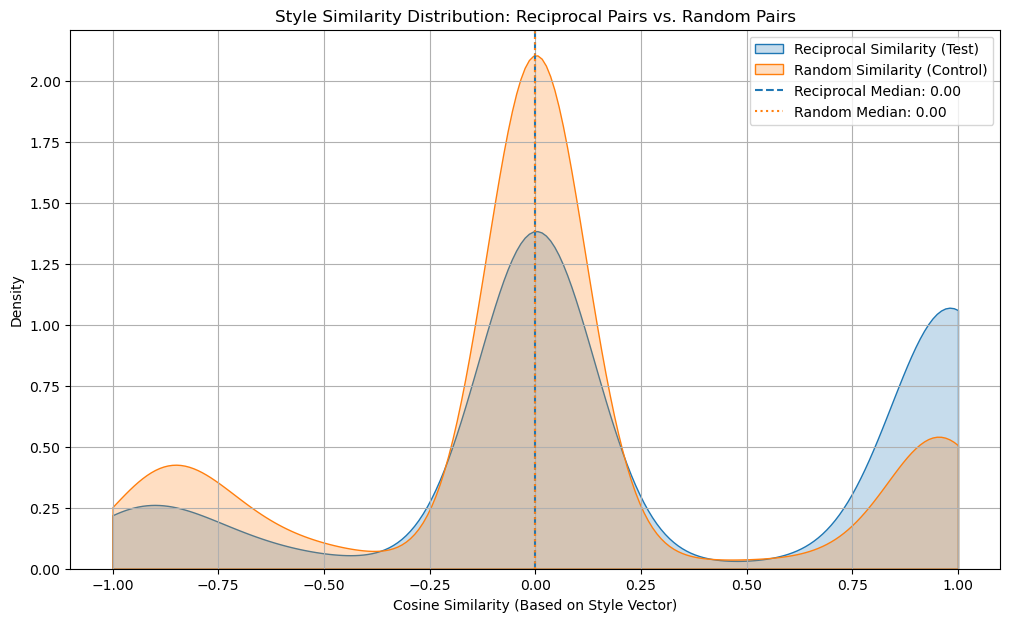

In [27]:
ut.response_similarity(df_country_exp, MAP_COUNTRY_EXPANDED)

# Political analysis

This analysis identifies interactions between a country's subreddit and a subreddit associated with a specific political ideology.


### 1. Load Political Analysis Data

We'll load the political subreddits obteined with `filter_politic_subreddits.ipynb`.

In [ ]:
POLITIC_FILE="data/politic_subreddit.csv"
df_politic=pd.read_csv(POLITIC_FILE)

### 2. Analyze activity by political subreddits

In [ ]:
activity_results = ut.analyze_political_activity(df_posts, df_politic)

print("\n--- Political Activity Summary ---")
print(f"Total Posts Involving Political Subreddits: {activity_results['total_political_posts']:,}")
    
print("\nMost Active Subreddit:")
print(f"  Name:  {activity_results['most_active_subreddit']['name']}")
print(f"  Posts: {activity_results['most_active_subreddit']['posts']:,}")

print("\nMost Active Ideology:")
print(f"  Name:  {activity_results['most_active_ideology']['name']}")
print(f"  Posts: {activity_results['most_active_ideology']['posts']:,}")
    
print("\n--- Top 10 Most Active Ideologies ---")
display(activity_results['ideology_activity_summary'].head(10))
    
print("\n--- Top 10 Most Active Subreddits ---")
display(activity_results['subreddit_activity_summary'].head(10))

Analyzing political subreddit activity...
Activity analysis complete.

--- Political Activity Summary ---
Total Posts Involving Political Subreddits: 34,639

Most Active Subreddit:
  Name:  shitliberalssay
  Posts: 3,922

Most Active Ideology:
  Name:  right
  Posts: 16,091

--- Top 10 Most Active Ideologies ---


ideology
right              16091
left               12635
center_or_other    10404
Name: count, dtype: int64


--- Top 10 Most Active Subreddits ---


shitliberalssay          3922
anarcho_capitalism       3759
europe                   3157
socialism                2561
enoughlibertarianspam    2557
libertarian              2324
anarchism                2307
latestagecapitalism      1624
conservative             1405
islam                    1398
Name: count, dtype: int64

### 3. Compute interactions

In [ ]:
df_pure_summary_2015 = ut.analyze_pure_cross_interactions(
    df_posts,   
    df_countries,   
    df_politic
)

display(df_pure_summary_2015)

--- Step 1: Create Mutually Exclusive Subreddit Sets ---
Loaded 3542 'Pure' Country Subreddits.
Loaded 451 'Pure' Political Subreddits.

Filtering DataFrame...
TIMESTAMP column is datetime.
Rows after LINK_SENTIMENT == 1 filter: 776278
Rows after Year == 2015 filter: 238439

Filtering for pure cross-interactions (both directions)...
Found 838 total interactions matching all criteria.
Loaded 3602 country mappings.
Loaded 511 ideology mappings.
Temporary 'Country' and 'Ideology' columns created.

Aggregating results...

--- Analysis Complete ---


Ideology,center_or_other,left,right,Total_Interactions
Country,,,,
USA,88,16,56,160
Canada,18,10,43,71
Sri Lanka,50,13,0,63
United Kingdom,18,12,5,35
Sweden,21,10,1,32
...,...,...,...,...
Egypt,0,0,1,1
Cyprus,1,0,0,1
Cuba,1,0,0,1


We can say that although right subreddits tend to post more they don't have many interactions with country related subreddits. Instead we can clearly see that there is a surprising number of interactions between centre subreddits wihich put in evudence how this ideology is more inclined to the positive discussion and debate

# Sport Analysis

This analysis answers the question: **"Which single sport is the most popular (has the most interactions) in each country?"**

### 1. Load Sport Analysis Data

We'll load the (`df_country_sports`) obteined with `filter_sports.py`. 

This file is special: an interaction can be `Country -> Sport` or `Sport -> Country`. This means a single row might have a `NaN` value in either `SOURCE_COUNTRY` or `TARGET_COUNTRY`.


In [29]:
SPORT_FILE = str("data/df_country_sport.csv")
df_analysis = pd.read_csv(SPORT_FILE)

### 2. Clean the dataset 

Create one 'Country' column
It takes the value from 'SOURCE_COUNTRY'. If that is NaN, it fills it with the value from 'TARGET_COUNTRY'.
Same with 'Sport'.

In [30]:
df_analysis['Country'] = df_analysis['SOURCE_COUNTRY'].fillna(df_analysis['TARGET_COUNTRY'])

df_analysis['Sport'] = df_analysis['SPORT_SOURCE'].fillna(df_analysis['SPORT_TARGET'])

### 3. Agregate interactions 

We group by the new clean columns and count the occurrences

In [31]:
agg_interactions = df_analysis.groupby(['Country', 'Sport']).size().reset_index(name='total_interactions')

### 4. Find the Top Sport for Each Country 

In [33]:
# Find the index (row number) of the maximum interaction count *within* each country group
idx_of_max_per_group = agg_interactions.groupby('Country')['total_interactions'].idxmax()

# Select only those rows using .loc[]
df_top_sport_per_country = agg_interactions.loc[idx_of_max_per_group]

# Sort the final list by interaction count for readability
df_top_sport_per_country = df_top_sport_per_country.sort_values('total_interactions', ascending=False)

print("\n--- Top Sport per Country (Ranked by Interaction Count) ---")
print(df_top_sport_per_country)


--- Top Sport per Country (Ranked by Interaction Count) ---
                  Country              Sport  total_interactions
285                   USA  American Football                 573
47                 Canada             Hockey                 129
138               Ireland             Soccer                  92
269                 Spain             Soccer                  88
149                 Italy             Soccer                  62
314        United Kingdom            Cricket                  58
89                 France            Cycling                  57
183           Netherlands             Soccer                  40
228              Portugal             Soccer                  40
15              Australia             Soccer                  26
240                Russia             Soccer                  25
117                 India            Cricket                  24
203                Norway             Soccer                  19
163                 Japan    